<h1 align="center">Cancer Cell Detection</h1>

#

In [2]:
# Install the Kaggle API client
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Move the Kaggle API key into the proper directory
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Use the Kaggle API to download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [03:50<00:00, 24.2MB/s]
100% 5.20G/5.20G [03:50<00:00, 24.2MB/s]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
# Extract the downloaded zip file
with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [9]:
# Define the path to the dataset
data_dir = '/content/dataset'

# Read the metadata file
metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# Display the metadata information
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


#

## Performing EDA

In [23]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Image 1


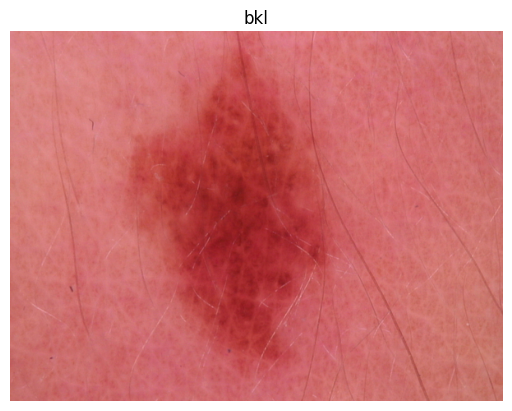


Image 2


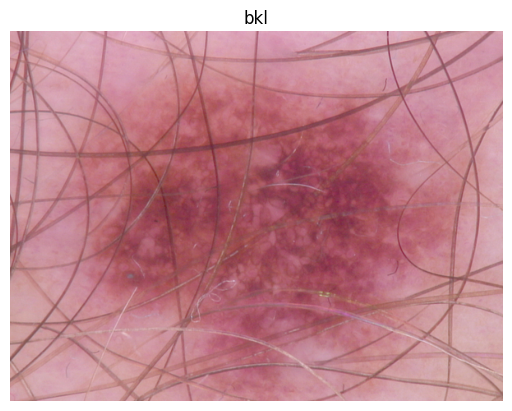


Image 3


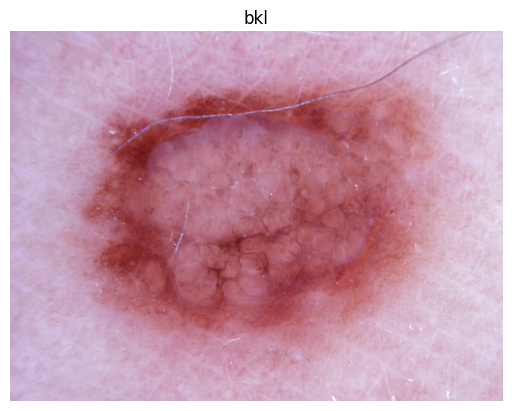


Image 4


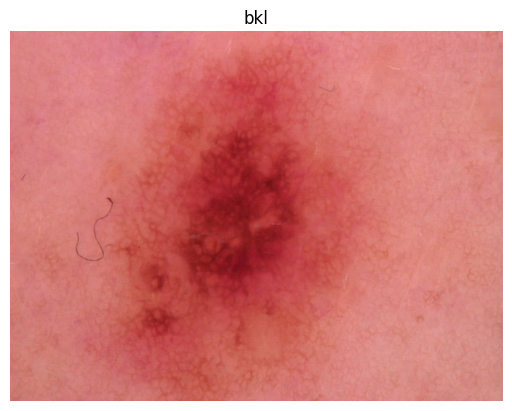


Image 5


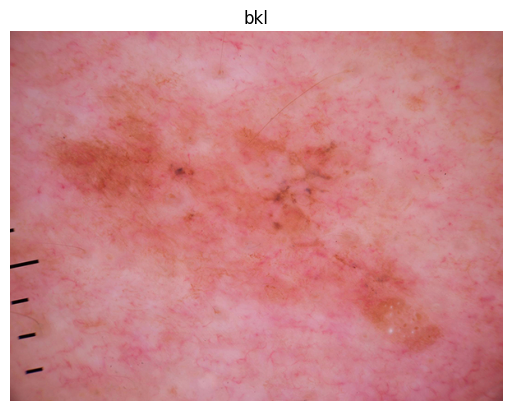

In [20]:
# Specify the image parts
image_parts = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

def display_image(image_id):
    for image_part in image_parts:
        image_path = os.path.join(data_dir, image_part, f'{image_id}.jpg')
        if os.path.exists(image_path):
            image = Image.open(image_path)
            label = metadata.loc[idx, 'dx']
            plt.imshow(image)
            plt.title(label)
            plt.axis('off')
            plt.show()
            print()
            return
    print(f"Image '{image_id}.jpg' does not exist in 'HAM10000_images_part_1' or 'HAM10000_images_part_2' directory.")

# Display 5 random images
for _ in range(5):
    # Generate a random image ID
    random_image_id = random.choice(os.listdir(os.path.join(data_dir, random.choice(image_parts))))
    image_id = os.path.splitext(random_image_id)[0]  # Remove the file extension
    print(f"Image {_+1}")
    display_image(image_id)

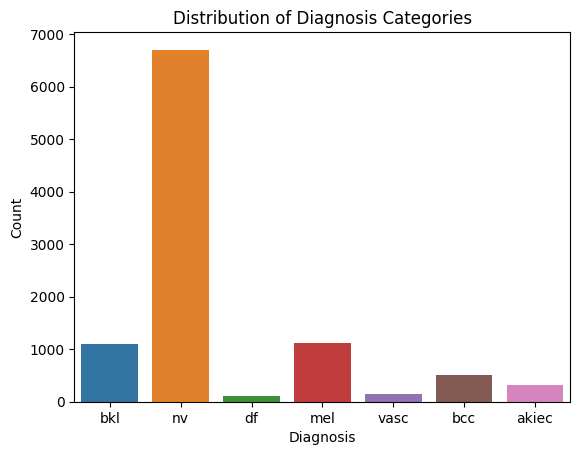

In [27]:
# Display the distribution of different diagnosis categories
sns.countplot(x = 'dx', data = metadata)
plt.title('Distribution of Diagnosis Categories')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [29]:
metadata['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

Text(0.5, 1.0, 'Distribution Of Gender')

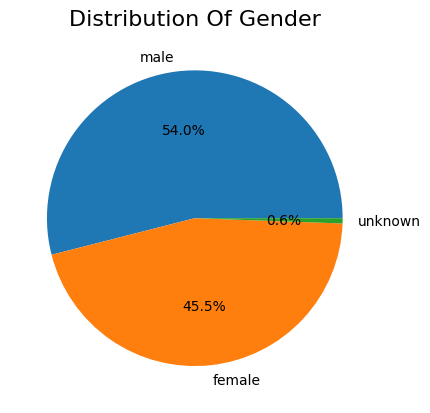

In [28]:
# Distribution Of Gender
plt.pie(metadata['sex'].value_counts(), labels = metadata['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Distribution Of Gender', size=16)

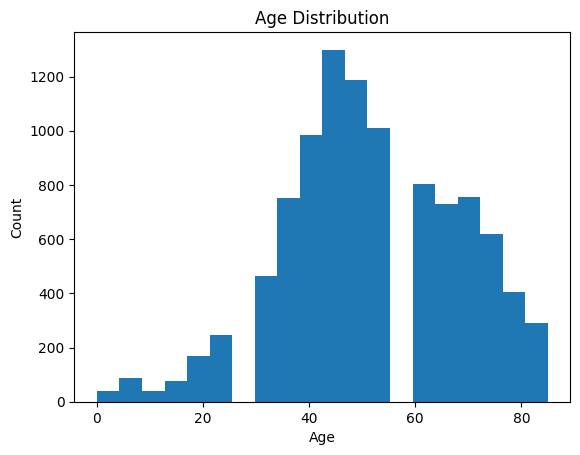

In [30]:
# Display the age distribution
metadata['age'].plot(kind='hist', bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

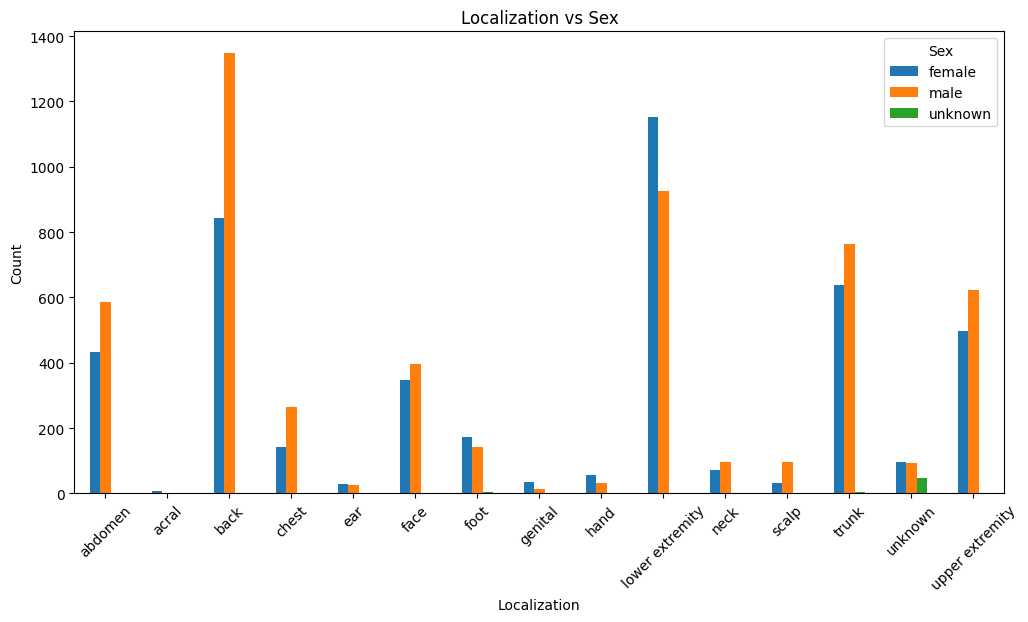

In [35]:
# Gender Vs localization
grouped_data = metadata.groupby(['localization', 'sex']).size().unstack()

# Plot the grouped bar plot
grouped_data.plot(kind='bar', figsize=(12, 6))
plt.title('Localization vs Sex')
plt.xlabel('Localization')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.xticks(rotation=45)
plt.show()

#

## Image Loading & Preprocessing

In [36]:
# Load the images from the dataset
images = []
labels = []

for image_name in metadata['image_id']:
    image_path_part_1 = os.path.join(data_dir, 'HAM10000_images_part_1', f'{image_name}.jpg')
    image_path_part_2 = os.path.join(data_dir, 'HAM10000_images_part_2', f'{image_name}.jpg')

    if os.path.exists(image_path_part_1):
        image_path = image_path_part_1
    elif os.path.exists(image_path_part_2):
        image_path = image_path_part_2
    else:
        continue

    image = Image.open(image_path)
    image = image.resize((32, 32))  # Resize the image for consistency
    image = np.array(image)
    images.append(image)

    label = metadata[metadata['image_id'] == image_name]['dx'].values[0]
    labels.append(label)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Perform label encoding on the target variable
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

#

## Model Building

In [45]:
# Create a sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Apply data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)

In [50]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, epochs=20)

Epoch 1/20
250/250 [==============================] - 7s 19ms/step - loss: 1.0625 - accuracy: 0.6667
Epoch 2/20
250/250 [==============================] - 5s 19ms/step - loss: 0.9513 - accuracy: 0.6725
Epoch 3/20
250/250 [==============================] - 6s 25ms/step - loss: 0.9124 - accuracy: 0.6796
Epoch 4/20
250/250 [==============================] - 5s 19ms/step - loss: 0.8996 - accuracy: 0.6822
Epoch 5/20
250/250 [==============================] - 6s 25ms/step - loss: 0.8783 - accuracy: 0.6833
Epoch 6/20
250/250 [==============================] - 5s 19ms/step - loss: 0.8515 - accuracy: 0.6873
Epoch 7/20
250/250 [==============================] - 6s 23ms/step - loss: 0.8309 - accuracy: 0.6927
Epoch 8/20
250/250 [==============================] - 5s 19ms/step - loss: 0.8065 - accuracy: 0.7021
Epoch 9/20
250/250 [==============================] - 6s 24ms/step - loss: 0.7959 - accuracy: 0.7051
Epoch 10/20
250/250 [==============================] - 5s 18ms/step - loss: 0.7696 - accura

#

## Model Evaluation

In [51]:
import warnings
warnings.filterwarnings("ignore")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

63/63 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.7399
Test Loss: 0.696417510509491
Test Accuracy: 0.7398901581764221


In [52]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Decode the labels
decoded_labels = label_encoder.inverse_transform(y_test)
decoded_predictions = label_encoder.inverse_transform(y_pred)

# Generate classification report and confusion matrix
print('Classification Report:')
print(classification_report(decoded_labels, decoded_predictions))

63/63 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

       akiec       0.39      0.16      0.23        69
         bcc       0.42      0.68      0.52        93
         bkl       0.54      0.33      0.41       228
          df       0.00      0.00      0.00        28
         mel       0.48      0.24      0.32       226
          nv       0.81      0.95      0.87      1338
        vasc       0.81      0.62      0.70        21

    accuracy                           0.74      2003
   macro avg       0.49      0.42      0.44      2003
weighted avg       0.70      0.74      0.71      2003



- Our Model give overall ~75% accuracy.

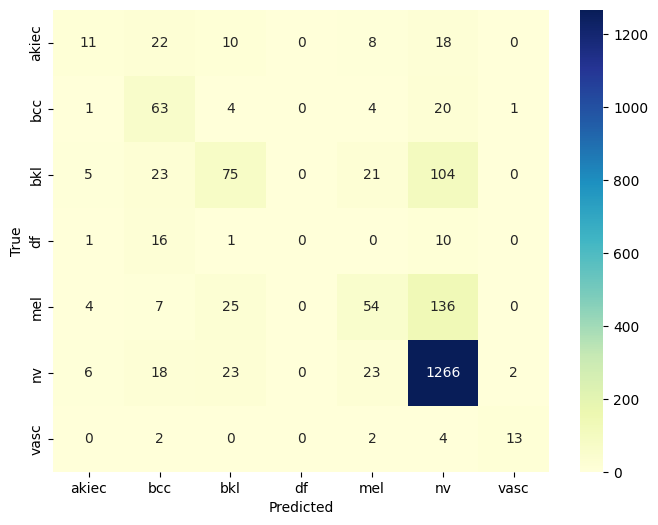

In [56]:
confusion_mtx = confusion_matrix(decoded_labels, decoded_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()